In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Read data 

In [2]:
df = pd.read_json("interaction.json", lines=True)

In [3]:
df.head()

,Item
0,{'visitorId': {'S': '23a9d176cb0a6f4e41f26bb61...
1,{'visitorId': {'S': '820c8d6b90bfc3154ea241f20...
2,{'visitorId': {'S': '906053f95a33732f207cdded4...
3,{'visitorId': {'S': 'de3043ff16009134fe548446c...
4,{'visitorId': {'S': '1a48d73af464a96f4b7365261...


# Inspect some data rows

In [4]:
pd.options.display.max_colwidth = 1000
print(df.loc[0],"\n")
print(df.loc[10],"\n")
print(df.loc[100],"\n")

Item    {'visitorId': {'S': '23a9d176cb0a6f4e41f26bb61167bd78'}, 'eventId': {'S': 'job-search-waitstaff'}, 'ttl': {'N': '1631185958.2'}, 'data': {'M': {'viewedAt': {'S': '2021-08-10T11:12:37.145Z'}, 'where': {'S': 'All Adelaide SA'}, 'source': {'S': 'web'}, 'roleId': {'S': 'waitstaff'}}}}
Name: 0, dtype: object 

Item    {'visitorId': {'S': '0b5d818cc24db9cc369bc2d452ee1676'}, 'eventId': {'S': 'job-search-business-administration-trainee'}, 'ttl': {'N': '1631151475.099'}, 'data': {'M': {'viewedAt': {'S': '2021-08-10T01:37:54.127Z'}, 'source': {'S': 'web'}, 'keywords': {'S': 'cs energy'}, 'roleId': {'S': 'business-administration-trainee'}}}}
Name: 10, dtype: object 

Item    {'visitorId': {'S': '1b39806bc72c5d2a1c088128fee7c51c'}, 'eventId': {'S': 'job-view-53088493'}, 'ttl': {'N': '1629937817.11'}, 'data': {'M': {'jobId': {'S': '53088493'}, 'roleId': {'S': 'team-member'}, 'locationId': {'N': '1004'}, 'workType': {'S': 'Casual/Vacation'}, 'viewedAt': {'S': '2021-07-27T00:30:16.231Z'}, 's

# Transition into Tabular data

## High-level Keys

In [5]:
res = pd.DataFrame()
res["visitorId"] = [s["visitorId"]["S"] for s in df["Item"]]
res["eventId"] = [s["eventId"]["S"] for s in df["Item"]]
res["ttl"] = [s["ttl"]["N"] for s in df["Item"]]
res["data"] = [s["data"]["M"] for s in df["Item"]]
res.head()

,visitorId,eventId,ttl,data
0,23a9d176cb0a6f4e41f26bb61167bd78,job-search-waitstaff,1631185958.2,"{'viewedAt': {'S': '2021-08-10T11:12:37.145Z'}, 'where': {'S': 'All Adelaide SA'}, 'source': {'S': 'web'}, 'roleId': {'S': 'waitstaff'}}"
1,820c8d6b90bfc3154ea241f20383313c,job-view-52939023,1629198877.076,"{'jobId': {'S': '52939023'}, 'roleId': {'S': 'care-coordinator'}, 'locationId': {'N': '5061'}, 'workType': {'S': 'Full Time'}, 'viewedAt': {'S': '2021-07-18T11:14:36.259Z'}, 'source': {'S': 'web'}, 'class': {'N': '6163'}}"
2,906053f95a33732f207cdded4ebcb320,job-search-aged-care-physiotherapist,1629873562.072,"{'viewedAt': {'S': '2021-07-26T06:39:21.174Z'}, 'where': {'S': 'Rockhampton & Capricorn Coast QLD'}, 'source': {'S': 'web'}, 'keywords': {'S': 'physiotherapist'}, 'roleId': {'S': 'aged-care-physiotherapist'}}"
3,de3043ff16009134fe548446c1b84b1f,job-search-business-development,1631236371.018,"{'viewedAt': {'S': '2021-08-11T01:12:50.446Z'}, 'source': {'S': 'web'}, 'keywords': {'S': 'intern'}, 'roleId': {'S': 'business-development'}}"
4,1a48d73af464a96f4b7365261d605147,job-search-office-administrator,1630667899.384,"{'viewedAt': {'S': '2021-08-04T11:18:18.968Z'}, 'where': {'S': 'All Canberra ACT'}, 'source': {'S': 'web'}, 'keywords': {'S': 'no experience'}, 'roleId': {'S': 'office-administrator'}}"


## Separate three type of events
This is because we see that the additional data is dependent on the type of event, so it will be easier to further flatten the data if we dedicate separate tabular dataframes to each type of event 

In [6]:
def get_sub_data(df, targetColumn, substring, newColumName):
    res = df[df[targetColumn].str.contains(substring)]
    res[targetColumn] = [s.replace(substring, "") for s in res[targetColumn]]
    res = res.rename(columns={targetColumn: newColumName})
    return res

def collect_all_keys(df, col):
    allKeys = []
    for s in df[col]:
        allKeys.extend(s.keys())
        
    return set(allKeys)

def clean_type_value_pair(pair):
    if pair == None:
        return np.nan
    if 'N' in pair:
        return int(pair['N'])
    elif 'S':
        return str(pair['S'])
    
def enrich_columns(df, targetColumn):
    subColumns = collect_all_keys(df, targetColumn)
    for col in subColumns:
        df[col] = [clean_type_value_pair(s.get(col)) for s in df[targetColumn]]# time stamp
    return df.drop(columns=[targetColumn])

## Event: Job Search

In [7]:
jobSearchDf = get_sub_data(res, "eventId", "job-search-", "job_name")
jobSearchDf = enrich_columns(jobSearchDf, "data")
jobSearchDf.head()

,visitorId,job_name,ttl,roleId,where,source,viewedAt,keywords
0,23a9d176cb0a6f4e41f26bb61167bd78,waitstaff,1631185958.2,waitstaff,All Adelaide SA,web,2021-08-10T11:12:37.145Z,NaN
2,906053f95a33732f207cdded4ebcb320,aged-care-physiotherapist,1629873562.072,aged-care-physiotherapist,Rockhampton & Capricorn Coast QLD,web,2021-07-26T06:39:21.174Z,physiotherapist
3,de3043ff16009134fe548446c1b84b1f,business-development,1631236371.018,business-development,NaN,web,2021-08-11T01:12:50.446Z,intern
4,1a48d73af464a96f4b7365261d605147,office-administrator,1630667899.384,office-administrator,All Canberra ACT,web,2021-08-04T11:18:18.968Z,no experience
5,87ab366c176cfcd792d4da020fabed78,Warehouse-Administration-Officer,1629597413.083,Warehouse-Administration-Officer,NaN,web,2021-07-23T01:56:52.167Z,NaN


## Event: Job View

In [8]:
jobViewDf = get_sub_data(res, "eventId", "job-view-", "job_number")
jobViewDf = enrich_columns(jobViewDf, "data")
jobViewDf.head()

,visitorId,job_number,ttl,roleId,workType,jobId,locationId,source,viewedAt,class
1,820c8d6b90bfc3154ea241f20383313c,52939023,1629198877.076,care-coordinator,Full Time,52939023,5061,web,2021-07-18T11:14:36.259Z,6163
6,3124ccf1f4a299a5a619cb69a5b2ac24,53096747,1629565817.937,warehouse-operator,Contract/Temp,53096747,1002,web,2021-07-22T17:10:16.919Z,6092
11,bd028c3b0e14f0c0ce9c157c50bcbc89,52765158,1629330148.315,safety-engineer,Full Time,52765158,1002,web,2021-07-19T23:42:27.565Z,1209
12,8204f1a52774ddf567403901aab347ec,52784534,1630154087.209,talent-acquisition-consultant,Full Time,52784534,1000,web,2021-07-29T12:34:46.642Z,1210
13,53278fbd8061da990a9e0715150e96db,52914193,1630199890.077,sales-support,Full Time,52914193,5047,web,2021-07-30T01:18:09.283Z,1204


## Event: Article View 

In [9]:
articleDf = get_sub_data(res, "eventId", "article-view-", "article_name")
articleDf = enrich_columns(articleDf, "data")
articleDf.head()

,visitorId,article_name,ttl,alias,articleId,viewedAt,topCategoryId,mainCategoryId,tag
32,1bb87dcbd0ee049d06dc435b3aa05715,the-5-skills-employers-want-now-and-how-to-show-them,1629182763.529,the-5-skills-employers-want-now-and-how-to-show-them,9090,2021-07-18T06:46:03.001Z,top-2,522,NaN
71,01fd8ac24911eeb68b02c57119590cd7,5-ways-to-deal-with-a-micromanaging-boss,1630782253.138,5-ways-to-deal-with-a-micromanaging-boss,701,2021-08-05T19:04:11.673Z,top-2,519,Settled
163,84a1de7f19962bb47229c8fa09ec45b9,5-ways-to-deal-with-a-micromanaging-boss,1629048840.676,5-ways-to-deal-with-a-micromanaging-boss,701,2021-07-16T17:33:59.421Z,top-2,519,Settled
282,6b058834e5f9b399d2f2a5acaed810f9,how-to-answer-where-do-you-see-yourself-in-5-years,1630297155.412,how-to-answer-where-do-you-see-yourself-in-5-years,331,2021-07-31T04:19:14.610Z,top-1,82,Active
295,be495cb086f0a1ac6e0b13ef2bbbe36b,free-resume-template,1628832286.052,free-resume-template,12,2021-07-14T05:24:45.205Z,top-0,289,Active


In [17]:
def conversio_rate_calculation (x, y):
    CR = x/y
    return CR

In [19]:
jobSearchDf.shape

(517620, 8)

In [28]:
jobViewDf.shape

(560658, 10)

In [29]:
articleDf.shape

(17695, 9)

# Merge Actions

## job search and job view on visitorId #1

In [14]:
jobSeachAndView1 = jobSearchDf.merge(jobViewDf, on=["visitorId"], how="inner")
jobSeachAndView1.head()

,visitorId,job_name,ttl_x,roleId_x,where,source_x,viewedAt_x,keywords,job_number,ttl_y,roleId_y,workType,jobId,locationId,source_y,viewedAt_y,class
0,af01d030e95292f2ae091d87fb950274,team-member,1631248159.538,team-member,bunbury,web,2021-08-11T04:29:18.748Z,cafe,53326017,1631251628.568,support-worker,Part Time,53326017,5047,web,2021-08-11T05:27:07.547Z,1211
1,d2baa6760f11aee816459898a8bf8c86,business-intelligence-developer,1629465376.819,business-intelligence-developer,All Melbourne VIC,web,2021-07-21T13:16:15.896Z,power bi developer,52966304,1629466020.362,pmo-analyst,Full Time,52966304,1002,web,2021-07-21T13:26:59.377Z,6281
2,3d27299f-a4aa-4a9d-a258-b0026c2fcd31,continuous-improvement-manager,1629703521.547,continuous-improvement-manager,All Brisbane QLD,web,2021-07-24T07:25:20.491Z,compliance,53166941,1630025320.978,safety-adviser,Full Time,53166941,1004,web,2021-07-28T00:48:40.112Z,1206
3,3d27299f-a4aa-4a9d-a258-b0026c2fcd31,continuous-improvement-manager,1629703521.547,continuous-improvement-manager,All Brisbane QLD,web,2021-07-24T07:25:20.491Z,compliance,53136111,1629967294.009,sheq-advisor_2,Full Time,53136111,5015,web,2021-07-27T08:41:33.351Z,6317
4,3d27299f-a4aa-4a9d-a258-b0026c2fcd31,case-assessor,1631234912.839,case-assessor,All Brisbane QLD,web,2021-08-11T00:48:32.098Z,compliance,53166941,1630025320.978,safety-adviser,Full Time,53166941,1004,web,2021-07-28T00:48:40.112Z,1206


In [18]:
jobSeachAndView1.shape

(182323, 17)

In [32]:
CRforSearchandView1 = conversio_rate_calculation (182323, 517620)
print ('Conversion rate of job search to job view :', CRforSearchandView1)

Conversion rate of job search to job view : 0.3522332985587883


In [36]:
GroupedDataSandV1 = jobSeachAndView1.groupby(by="where").size().sort_values(ascending=False)
GroupedDataSandV1.head() 

where
All Melbourne VIC    19161
All Sydney NSW       13282
All Perth WA         12397
All Brisbane QLD     10246
All Adelaide SA       7305
dtype: int64

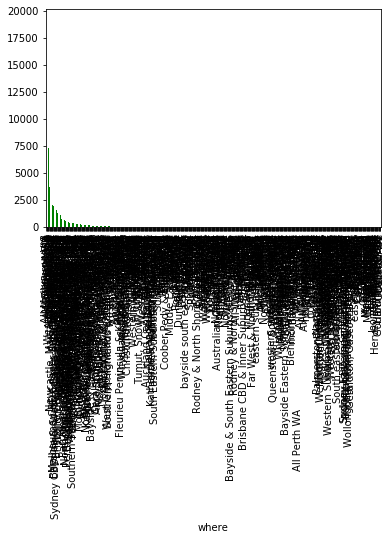

In [35]:
GroupedDataSandV1.plot.bar(color=['green'])

## job search and article view on visitorId #1 

In [15]:
jobSeachAndArticle1 = jobSearchDf.merge(articleDf, on=["visitorId"], how="inner")
jobSeachAndArticle1.head()

,visitorId,job_name,ttl_x,roleId,where,source,viewedAt_x,keywords,article_name,ttl_y,alias,articleId,viewedAt_y,topCategoryId,mainCategoryId,tag
0,e5ba49e2e3d3e5dfceace7ff03753183,marketing-and-communications-manager,1629324979.76,marketing-and-communications-manager,All Canberra ACT,web,2021-07-19T22:16:19.193Z,NaN,4-things-your-cover-letter-must-include-this-year,1631138799.865,4-things-your-cover-letter-must-include-this-year,97,2021-08-09T22:06:38.885Z,top-1,516,Active
1,e5ba49e2e3d3e5dfceace7ff03753183,demolition-labourer,1630547671.972,demolition-labourer,All Canberra ACT,web,2021-08-03T01:54:30.969Z,NaN,4-things-your-cover-letter-must-include-this-year,1631138799.865,4-things-your-cover-letter-must-include-this-year,97,2021-08-09T22:06:38.885Z,top-1,516,Active
2,e5ba49e2e3d3e5dfceace7ff03753183,program-officer,1630733021.327,program-officer,All Canberra ACT,web,2021-08-05T05:23:40.505Z,NaN,4-things-your-cover-letter-must-include-this-year,1631138799.865,4-things-your-cover-letter-must-include-this-year,97,2021-08-09T22:06:38.885Z,top-1,516,Active
3,e5ba49e2e3d3e5dfceace7ff03753183,copywriter,1630732635.265,copywriter,All Canberra ACT,web,2021-08-05T05:17:14.726Z,NaN,4-things-your-cover-letter-must-include-this-year,1631138799.865,4-things-your-cover-letter-must-include-this-year,97,2021-08-09T22:06:38.885Z,top-1,516,Active
4,e5ba49e2e3d3e5dfceace7ff03753183,health-safety-and-environment-manager,1629324857.434,health-safety-and-environment-manager,All Canberra ACT,web,2021-07-19T22:14:17.060Z,NaN,4-things-your-cover-letter-must-include-this-year,1631138799.865,4-things-your-cover-letter-must-include-this-year,97,2021-08-09T22:06:38.885Z,top-1,516,Active


In [21]:
jobSeachAndArticle1.shape

(854, 16)

In [31]:
CRforSearchandArticle1 = conversio_rate_calculation (854, 517620)
print ('Conversion rate of job search to article view :', CRforSearchandArticle1)

Conversion rate of job search to article view : 0.0016498589699006994


In [37]:
GroupedDataSandA1 = jobSeachAndArticle1.groupby(by="where").size().sort_values(ascending=False)
GroupedDataSandA1.head()

where
All Melbourne VIC    118
All Sydney NSW        70
All Perth WA          58
All Brisbane QLD      47
All Adelaide SA       41
dtype: int64

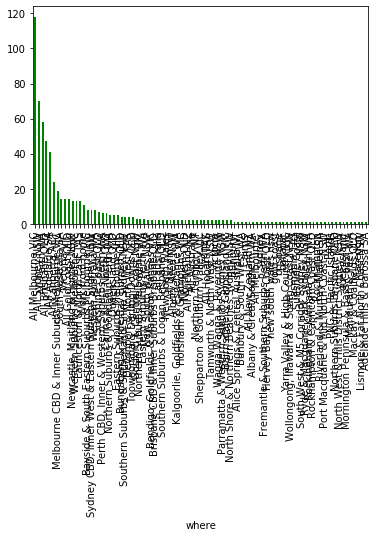

In [38]:
GroupedDataSandA1.plot.bar(color=['green'])

## job view and article view on visitorId #1 

In [16]:
jobViewAndArticle1 = jobViewDf.merge(articleDf, on=["visitorId"], how="inner")
jobViewAndArticle1.head()

,visitorId,job_number,ttl_x,roleId,workType,jobId,locationId,source,viewedAt_x,class,article_name,ttl_y,alias,articleId,viewedAt_y,topCategoryId,mainCategoryId,tag
0,611cf4dab22cf959871bd17c06033038,52980275,1628913888.305,data-entry-officer,Contract/Temp,52980275,1015,web,2021-07-15T04:04:47.529Z,6251,4-ways-to-talk-confidently-about-your-skills,1629239903.735,4-ways-to-talk-confidently-about-your-skills,12712,2021-07-18T22:38:22.528Z,top-2,522,NaN
1,b9c28b29e8ba56c15c80160fd02d5a00,53370609,1631081422.577,marketing-communications-manager,Full Time,53370609,1000,web,2021-08-09T06:10:21.971Z,6008,8-things-you-didnt-know-you-could-be-fired-for,1628767581.864,8-things-you-didnt-know-you-could-be-fired-for,8233,2021-07-13T11:26:21.494Z,top-2,521,NaN
2,b9c28b29e8ba56c15c80160fd02d5a00,53177099,1630046188.4,consultant,Contract/Temp,53177099,1000,web,2021-07-28T06:36:28.052Z,6163,8-things-you-didnt-know-you-could-be-fired-for,1628767581.864,8-things-you-didnt-know-you-could-be-fired-for,8233,2021-07-13T11:26:21.494Z,top-2,521,NaN
3,b9c28b29e8ba56c15c80160fd02d5a00,53188289,1630071077.598,digital-producer,Contract/Temp,53188289,1000,web,2021-07-28T13:31:16.990Z,6008,8-things-you-didnt-know-you-could-be-fired-for,1628767581.864,8-things-you-didnt-know-you-could-be-fired-for,8233,2021-07-13T11:26:21.494Z,top-2,521,NaN
4,b9c28b29e8ba56c15c80160fd02d5a00,52810782,1628761864.566,digital-content-writer,Full Time,52810782,1000,web,2021-07-13T09:51:03.635Z,6304,8-things-you-didnt-know-you-could-be-fired-for,1628767581.864,8-things-you-didnt-know-you-could-be-fired-for,8233,2021-07-13T11:26:21.494Z,top-2,521,NaN


In [27]:
jobViewAndArticle1.shape

(800, 18)

In [30]:
CRforViewandArticle1 = conversio_rate_calculation (800, 560658)
print ('Conversion rate of job view to article view :', CRforViewandArticle1)

Conversion rate of job view to article view : 0.0014268948271495279


In [40]:
GroupedDataVandA1 = jobViewAndArticle1.groupby(by="locationId").size().sort_values(ascending=False)
GroupedDataVandA1.head()

locationId
1002    228
1000    132
1004    104
1009     62
1007     61
dtype: int64

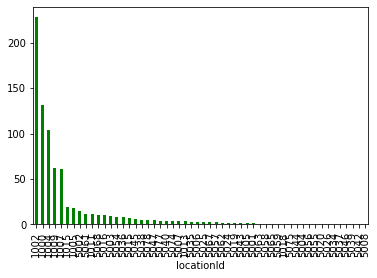

In [41]:
GroupedDataVandA1.plot.bar(color=['green'])

# job search and job view on viewedAt #2

In [45]:
! pip install pandasql

  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26822 sha256=4c047c6e1ce1f5620ab1e5acbb05fede49b9cb60a1da36b23105e392b771f6b7
  Stored in directory: c:\users\e94290\appdata\local\pip\cache\wheels\5c\4b\ec\41f4e116c8053c3654e2c2a47c62b4fca34cc67ef7b55deb7f
Successfully built pandasql


In [46]:
import pandasql as ps

In [49]:
sqlcode = '''
select jobSearchDf.visitorId
from jobSearchDf
inner join jobViewDf on jobSearchDf.visitorId=jobViewDf.visitorId
where jobSearchDf.viewedAt BETWEEN jobViewDf.viewedAt +12 AND jobViewDf.viewedAt -12 
group by jobSearchDf.visitorId
'''
newdf = ps.sqldf(sqlcode,locals())

In [51]:
newdf.shape

(0, 1)

# Time change to timestamps 

In [64]:
jobSearchDf['viewedAt'] = pd.to_datetime(jobSearchDf['viewedAt']).dt.tz_convert(None)

TypeError: Cannot convert tz-naive timestamps, use tz_localize to localize

In [63]:
jobSearchDf.head()

,visitorId,job_name,ttl,roleId,where,source,viewedAt,keywords
0,23a9d176cb0a6f4e41f26bb61167bd78,waitstaff,1631185958.2,waitstaff,All Adelaide SA,web,2021-08-10 11:12:37.145,NaN
2,906053f95a33732f207cdded4ebcb320,aged-care-physiotherapist,1629873562.072,aged-care-physiotherapist,Rockhampton & Capricorn Coast QLD,web,2021-07-26 06:39:21.174,physiotherapist
3,de3043ff16009134fe548446c1b84b1f,business-development,1631236371.018,business-development,NaN,web,2021-08-11 01:12:50.446,intern
4,1a48d73af464a96f4b7365261d605147,office-administrator,1630667899.384,office-administrator,All Canberra ACT,web,2021-08-04 11:18:18.968,no experience
5,87ab366c176cfcd792d4da020fabed78,Warehouse-Administration-Officer,1629597413.083,Warehouse-Administration-Officer,NaN,web,2021-07-23 01:56:52.167,NaN


In [66]:
jobViewDf['viewedAt'] = pd.to_datetime(jobViewDf['viewedAt']).dt.tz_convert(None)

In [67]:
jobViewDf.head()

,visitorId,job_number,ttl,roleId,workType,jobId,locationId,source,viewedAt,class
1,820c8d6b90bfc3154ea241f20383313c,52939023,1629198877.076,care-coordinator,Full Time,52939023,5061,web,2021-07-18 11:14:36.259,6163
6,3124ccf1f4a299a5a619cb69a5b2ac24,53096747,1629565817.937,warehouse-operator,Contract/Temp,53096747,1002,web,2021-07-22 17:10:16.919,6092
11,bd028c3b0e14f0c0ce9c157c50bcbc89,52765158,1629330148.315,safety-engineer,Full Time,52765158,1002,web,2021-07-19 23:42:27.565,1209
12,8204f1a52774ddf567403901aab347ec,52784534,1630154087.209,talent-acquisition-consultant,Full Time,52784534,1000,web,2021-07-29 12:34:46.642,1210
13,53278fbd8061da990a9e0715150e96db,52914193,1630199890.077,sales-support,Full Time,52914193,5047,web,2021-07-30 01:18:09.283,1204


In [68]:
articleDf['viewedAt'] = pd.to_datetime(articleDf['viewedAt']).dt.tz_convert(None)

In [69]:
articleDf.head()

,visitorId,article_name,ttl,alias,articleId,viewedAt,topCategoryId,mainCategoryId,tag
32,1bb87dcbd0ee049d06dc435b3aa05715,the-5-skills-employers-want-now-and-how-to-show-them,1629182763.529,the-5-skills-employers-want-now-and-how-to-show-them,9090,2021-07-18 06:46:03.001,top-2,522,NaN
71,01fd8ac24911eeb68b02c57119590cd7,5-ways-to-deal-with-a-micromanaging-boss,1630782253.138,5-ways-to-deal-with-a-micromanaging-boss,701,2021-08-05 19:04:11.673,top-2,519,Settled
163,84a1de7f19962bb47229c8fa09ec45b9,5-ways-to-deal-with-a-micromanaging-boss,1629048840.676,5-ways-to-deal-with-a-micromanaging-boss,701,2021-07-16 17:33:59.421,top-2,519,Settled
282,6b058834e5f9b399d2f2a5acaed810f9,how-to-answer-where-do-you-see-yourself-in-5-years,1630297155.412,how-to-answer-where-do-you-see-yourself-in-5-years,331,2021-07-31 04:19:14.610,top-1,82,Active
295,be495cb086f0a1ac6e0b13ef2bbbe36b,free-resume-template,1628832286.052,free-resume-template,12,2021-07-14 05:24:45.205,top-0,289,Active


In [70]:
sqlcode = '''
select jobSearchDf.visitorId
from jobSearchDf
inner join jobViewDf on jobSearchDf.visitorId=jobViewDf.visitorId
where jobSearchDf.viewedAt BETWEEN jobViewDf.viewedAt +12 AND jobViewDf.viewedAt -12 
group by jobSearchDf.visitorId
'''
newdf = ps.sqldf(sqlcode,locals())